In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


In [3]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


Create the target variable by mapping yes to 1 and no to 0.

In [4]:
df.card = (df.card == 'yes').astype(int)
#df.owner = (df.owner == 'yes').astype(int)
#df.selfemp = (df.selfemp == 'yes').astype(int)

Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1.

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

ROC AUC could also be used to evaluate feature importance of numerical variables.

For each numerical variable, use it as score and compute AUC with the card variable.
Use the training dataset for that.
If your AUC is < 0.5, invert this variable by putting "-" in front (e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

In [6]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score

In [8]:
res = []

for variable in ['reports','age','income','share','expenditure','dependents','months','majorcards','active']:
    model = LogisticRegression()
    model.fit(df_train[[variable]], y_train)
    y_pred = model.predict_proba(df_train[[variable]])[:,1]
    res.append((variable, roc_auc_score(y_train, y_pred).round(4)))

In [9]:
print(res)

[('reports', 0.7167), ('age', 0.524), ('income', 0.5908), ('share', 0.9892), ('expenditure', 0.991), ('dependents', 0.5328), ('months', 0.5294), ('majorcards', 0.5344), ('active', 0.6043)]


From now on, use these columns only:

['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active', 'owner', 'selfemp']
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [10]:
columns = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 
           'months', 'majorcards', 'active', 'owner', 'selfemp']

df_train = df_train[columns]
df_val = df_val[columns]

dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient="records")
x_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient="records")
x_val = dv.fit_transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(x_train, y_train)

y_pred = model.predict_proba(x_val)[:,1]

print(roc_auc_score(y_val, y_pred).round(3))

0.995


Now let's compute precision and recall for our model.

Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

In [11]:
thresholds = np.arange(0, 1.01, 0.01)

scores = []
for t in thresholds:
    real_positive = (y_val == 1)
    real_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & real_positive).sum()
    tn = (predict_negative & real_negative).sum()

    fp = (predict_positive & real_negative).sum()
    fn = (predict_negative & real_positive).sum()
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    scores.append((t, precision, recall))

In [13]:
df_scores = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall'])
df_scores

,threshold,precision,recall
0,0.00,0.799242,1.000000
1,0.01,0.861224,1.000000
2,0.02,0.871901,1.000000
3,0.03,0.897872,1.000000
4,0.04,0.905579,1.000000
...,...,...,...
96,0.96,1.000000,0.966825
97,0.97,1.000000,0.962085
98,0.98,1.000000,0.962085
99,0.99,1.000000,0.957346


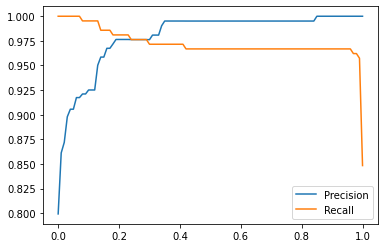

In [14]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

Precision and recall are conflicting - when one grows, the other goes down. 
That's why they are often combined into the F1 score - a metrics that takes into account both

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

In [15]:
df_scores['f1'] = (2*df_scores['precision']*df_scores['recall'])/(df_scores['precision']+df_scores['recall'])

In [18]:
df_scores[df_scores['f1'] == df_scores['f1'].max()]

,threshold,precision,recall,f1
35,0.35,0.995146,0.971564,0.983213
36,0.36,0.995146,0.971564,0.983213
37,0.37,0.995146,0.971564,0.983213
38,0.38,0.995146,0.971564,0.983213
39,0.39,0.995146,0.971564,0.983213
40,0.40,0.995146,0.971564,0.983213
41,0.41,0.995146,0.971564,0.983213


Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:
KFold(n_splits=5, shuffle=True, random_state=1)

Iterate over different folds of df_full_train

Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard devidation of the AUC scores across different folds?

In [19]:
from sklearn.model_selection import KFold
!pip install tqdm
from tqdm.auto import tqdm

In [21]:
def train(df_train, y_train, C):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [22]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [23]:
np.std(scores)

0.0027434713804377724

Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 1, 10]
Initialize KFold with the same parameters as previously
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [25]:
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print((C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

(0.01, 0.9918810292344007, 0.00559887235402738)
(0.1, 0.9950557137157224, 0.003954138088244392)
(1, 0.9964498276814243, 0.0027434713804377724)
(10, 0.9963886109436032, 0.0028151486609295684)
